--- Datos Originales ---
   Antiguedad_Meses  Cargos_Mensuales  Cargos_Totales     Genero Tiene_Pareja  \
0                52        105.569647     3241.879811   Femenino           No   
1                15        103.021986     6410.564201  Masculino           No   
2                61         59.718353     1672.083295   Femenino           Si   
3                21         86.808514     4462.925347   Femenino           No   
4                24         40.498430     5877.916803   Femenino           No   

  Tiene_Dependientes Servicio_Telefono Multiples_Lineas Servicio_Internet  \
0                 No                No               No               DSL   
1                 No                Si               Si      Fibra Optica   
2                 Si                Si               Si      Fibra Optica   
3                 Si                No               No                No   
4                 Si                Si               Si      Fibra Optica   

  Tipo_Contrato          

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Mejores hiperparámetros encontrados: {'classifier__subsample': 0.6, 'classifier__scale_pos_weight': np.float64(4.0), 'classifier__reg_lambda': 0.1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}
Mejor Recall en CV: 0.8625

--- Evaluación del Modelo Final en el Conjunto de Prueba ---
Accuracy: 0.2350
Precision: 0.1946
Recall: 0.9000
F1-Score: 0.3200
AUC-ROC: 0.4959


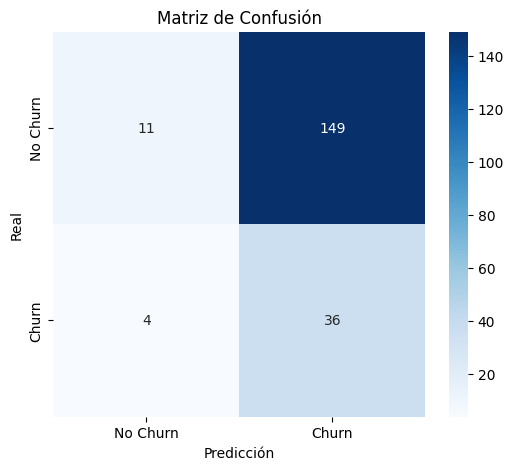

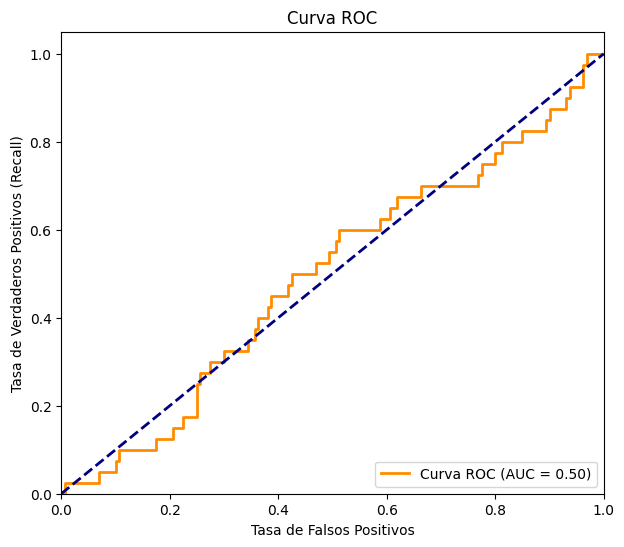

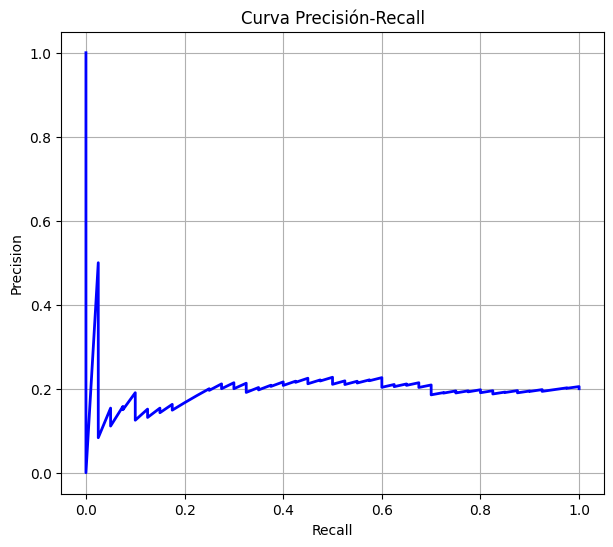


--- Interpretación del Modelo (SHAP) ---

Gráfico de resumen SHAP (Importancia global de las características):


<ipython-input-2-2691161179>:259: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)


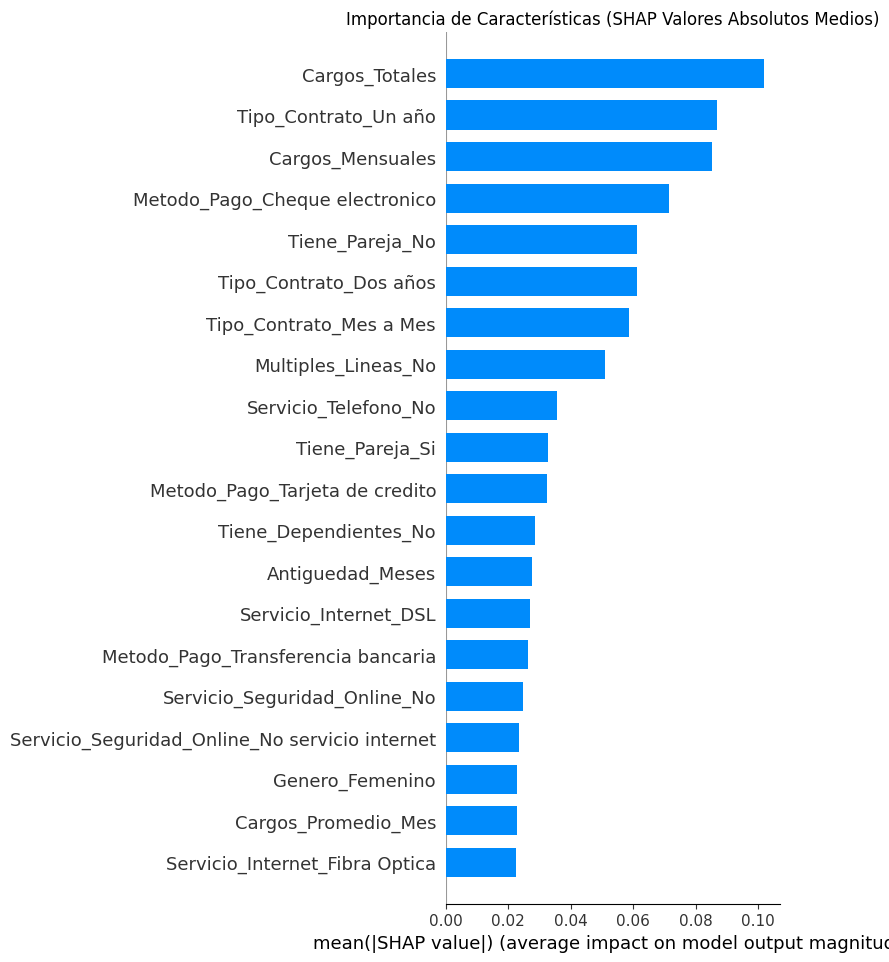


Gráfico de dependencia SHAP para la característica: Cargos_Totales


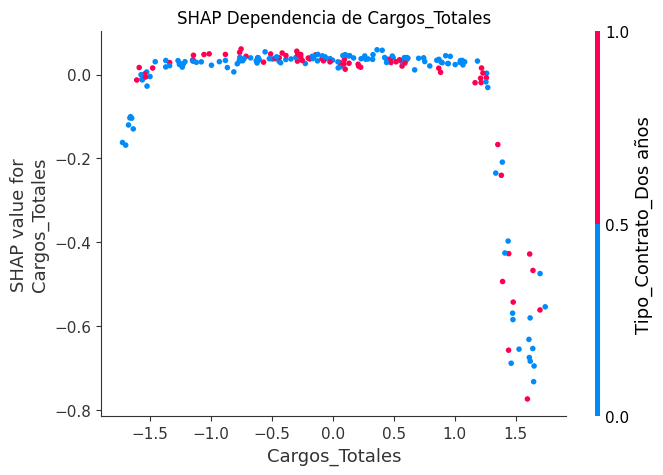


Explicación SHAP para una predicción individual (primer cliente):

--- Concepto de Despliegue (No ejecutable directamente) ---
El modelo 'best_model' puede ser guardado:
Y luego cargado en una API REST (e.g., con Flask/FastAPI) para servir predicciones:

--- Concepto de Monitoreo (No ejecutable directamente) ---
Para monitorear el modelo en producción, se compararían las distribuciones de las características de entrada a lo largo del tiempo con las usadas para entrenar, y se calcularían las métricas de rendimiento con datos reales a medida que estén disponibles.
Esto implicaría:
- Recopilar datos de entrada del modelo en producción.
- Recopilar la variable objetivo real de esos clientes después de un tiempo.
- Calcular Recall, Precision, F1-Score, AUC-ROC periódicamente.
- Alertar si hay un 'drift' significativo en las características o una degradación en el rendimiento.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap # Para la interpretabilidad

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# IMPORTANTE: Cambiar de sklearn.pipeline a imblearn.pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # Renombrado para evitar conflicto
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

# --- 1. Carga de Datos (Ejemplo: Datos ficticios o puedes cargar los tuyos) ---
# Generar datos ficticios para demostración
np.random.seed(42)
n_samples = 1000
data = {
    'Antiguedad_Meses': np.random.randint(1, 72, n_samples),
    'Cargos_Mensuales': np.random.uniform(20, 120, n_samples),
    'Cargos_Totales': np.random.uniform(50, 8000, n_samples),
    'Genero': np.random.choice(['Masculino', 'Femenino'], n_samples),
    'Tiene_Pareja': np.random.choice(['Si', 'No'], n_samples),
    'Tiene_Dependientes': np.random.choice(['Si', 'No'], n_samples),
    'Servicio_Telefono': np.random.choice(['Si', 'No'], n_samples),
    'Multiples_Lineas': np.random.choice(['Si', 'No'], n_samples),
    'Servicio_Internet': np.random.choice(['DSL', 'Fibra Optica', 'No'], n_samples),
    'Tipo_Contrato': np.random.choice(['Mes a Mes', 'Un año', 'Dos años'], n_samples),
    'Metodo_Pago': np.random.choice(['Cheque electronico', 'Cheque postal', 'Tarjeta de credito', 'Transferencia bancaria'], n_samples),
    'Servicio_Seguridad_Online': np.random.choice(['Si', 'No', 'No servicio internet'], n_samples),
    'Churn': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]) # 20% de churn para simular desequilibrio
}
df = pd.DataFrame(data)

# Introducir algunos valores faltantes para demostración
for col in ['Cargos_Totales', 'Servicio_Internet']:
    df.loc[np.random.choice(df.index, 20, replace=False), col] = np.nan

# Identificar la variable objetivo
TARGET = 'Churn'
X = df.drop(columns=[TARGET])
y = df[TARGET]

print("--- Datos Originales ---")
print(df.head())
print("\nInformación de los datos:")
print(df.info())
print("\nValores faltantes iniciales:")
print(df.isnull().sum())
print("\nDistribución de la variable objetivo:")
print(y.value_counts(normalize=True))

# --- 2. División de Datos (Estratificada) ---
# Usamos stratify=y para asegurar la misma proporción de 'Churn' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Proporción de Churn en y_train: {y_train.value_counts(normalize=True)[1]:.2f}")
print(f"Proporción de Churn en y_test: {y_test.value_counts(normalize=True)[1]:.2f}")

# --- 3. Preprocesamiento (Pipeline) ---
# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Crear pipelines para preprocesamiento numérico y categórico
numerical_transformer = ImbPipeline(steps=[ # Aquí también puedes usar sklearn.pipeline.Pipeline, no afecta si es el paso final
    ('imputer', SimpleImputer(strategy='median')), # Imputación con la mediana para numéricas
    ('scaler', StandardScaler()) # Escalado estándar
])

categorical_transformer = ImbPipeline(steps=[ # Aquí también puedes usar sklearn.pipeline.Pipeline
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputación con la moda para categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-Hot Encoding
])

# Crear un preprocesador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# --- 4. Manejo del Desequilibrio de Clases (SMOTE en el pipeline) ---
# Aplicaremos SMOTE después del preprocesamiento, antes de entrenar el modelo.
# Se suele aplicar solo en el conjunto de entrenamiento.

# --- 5. Ingeniería de Características (Ejemplo simple dentro del flujo) ---
# Una característica de ingeniería simple
# (En un proyecto real, esto podría ser una función más compleja o un paso separado)
def feature_engineer(df_input):
    df_engineered = df_input.copy()
    if 'Cargos_Totales' in df_engineered.columns and 'Antiguedad_Meses' in df_engineered.columns:
        # Evitar división por cero si Antiguedad_Meses es 0, reemplazar con 1 para evitar errores
        df_engineered['Cargos_Promedio_Mes'] = df_engineered['Cargos_Totales'] / df_engineered['Antiguedad_Meses'].replace(0, 1)
        # Manejar NaNs resultantes de Cargos_Totales si este estaba ausente
        df_engineered['Cargos_Promedio_Mes'] = df_engineered['Cargos_Promedio_Mes'].replace([np.inf, -np.inf], np.nan)

    # Otra característica: Si el cliente tiene internet pero no seguridad online (puede ser un riesgo)
    if 'Servicio_Internet' in df_engineered.columns and 'Servicio_Seguridad_Online' in df_engineered.columns:
        df_engineered['Tiene_Internet_Sin_Seguridad'] = ((df_engineered['Servicio_Internet'] != 'No') & (df_engineered['Servicio_Seguridad_Online'] == 'No')).astype(int)

    return df_engineered

# Aplicar ingeniería de características a los conjuntos de entrenamiento y prueba
X_train_eng = feature_engineer(X_train)
X_test_eng = feature_engineer(X_test)

# Actualizar las listas de columnas después de la ingeniería de características
# Es crucial que estas listas reflejen las columnas ANTES del ColumnTransformer
numerical_cols_eng = X_train_eng.select_dtypes(include=np.number).columns.tolist()
categorical_cols_eng = X_train_eng.select_dtypes(include='object').columns.tolist()

# Re-crear el preprocesador con las nuevas listas de columnas, si las características creadas son numéricas/categóricas y no fueron tratadas antes
# Nota: Si la característica nueva es una combinación de existentes y ya se manejan, no necesitas re-crear.
# Aquí, 'Cargos_Promedio_Mes' es numérica y 'Tiene_Internet_Sin_Seguridad' es numérica/binaria.
# Se aseguran de ser pasadas al ColumnTransformer.
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_eng),
        ('cat', categorical_transformer, categorical_cols_eng)
    ])


# --- 6. Modelado (XGBoost) y Pipeline Completo ---
# ¡Aquí está el cambio clave! Usamos ImbPipeline en lugar de sklearn.pipeline.Pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_eng),
    ('smote', SMOTE(random_state=42)), # Aplicar SMOTE solo al conjunto de entrenamiento, dentro del pipeline de CV
    ('classifier', xgb.XGBClassifier(objective='binary:logistic',
                                     eval_metric='logloss', # Métrica para la evaluación temprana
                                     use_label_encoder=False, # Deprecated, mejor establecer a False
                                     random_state=42))
])

# --- 7. Optimización de Hiperparámetros (RandomizedSearchCV con validación cruzada estratificada) ---
# Definir el espacio de hiperparámetros para la búsqueda
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__reg_alpha': [0, 0.005, 0.01, 0.1], # L1 regularization
    'classifier__reg_lambda': [0, 0.005, 0.01, 0.1], # L2 regularization
    # Calcular scale_pos_weight dinámicamente basado en los datos de entrenamiento
    'classifier__scale_pos_weight': [1, (y_train.value_counts()[0] / y_train.value_counts()[1])]
}

# Configurar StratifiedKFold para la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=50, # Número de combinaciones a probar
    scoring='recall', # Optimizar para Recall en la clase minoritaria
    cv=cv,
    verbose=1,
    n_jobs=-1, # Usar todos los núcleos disponibles
    random_state=42
)

print("\n--- Iniciando búsqueda de hiperparámetros (RandomizedSearchCV) ---")
random_search.fit(X_train_eng, y_train)

best_model = random_search.best_estimator_
print(f"\nMejores hiperparámetros encontrados: {random_search.best_params_}")
print(f"Mejor Recall en CV: {random_search.best_score_:.4f}")

# --- 8. Evaluación del Modelo Final ---
print("\n--- Evaluación del Modelo Final en el Conjunto de Prueba ---")
y_pred_proba = best_model.predict_proba(X_test_eng)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int) # Umbral por defecto de 0.5

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Curva Precisión-Recall
precision_points, recall_points, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(recall_points, precision_points, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precisión-Recall')
plt.grid(True)
plt.show()


# --- 9. Interpretación del Modelo (SHAP) ---
print("\n--- Interpretación del Modelo (SHAP) ---")

# Para SHAP, necesitamos el modelo entrenado y las características preprocesadas
# El preprocesador está dentro del `best_model` pipeline.
# Obtenemos las características transformadas del conjunto de prueba
# NOTA: En el caso de ImbPipeline, 'preprocessor' es el nombre del paso ColumnTransformer
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test_eng)

# Obtener los nombres de las características transformadas
# Las características numéricas conservan sus nombres
feature_names_numerical = numerical_cols_eng
# Las características categóricas necesitan obtener los nombres de las columnas one-hot-encoded
# Acceder al onehot encoder dentro del ColumnTransformer
onehot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
feature_names_categorical_encoded = onehot_encoder.get_feature_names_out(categorical_cols_eng)

# Combinar todos los nombres de las características
feature_names = numerical_cols_eng + list(feature_names_categorical_encoded)

# Crear un DataFrame con las características procesadas y sus nombres
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Crear un explainer de SHAP para el modelo XGBoost
# Acceder al clasificador dentro del pipeline
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_processed_df)

# Gráfico de resumen de SHAP (importancia global de las características)
print("\nGráfico de resumen SHAP (Importancia global de las características):")
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
plt.title('Importancia de Características (SHAP Valores Absolutos Medios)')
plt.show()

# Gráfico de dependencia de SHAP (impacto de una característica específica)
# Elegir una característica para visualizar su dependencia (ej. la más importante)
if feature_names:
    # Asegúrate de que shap_values no sea una lista si la predicción es binaria (shap_values[1] para la clase positiva)
    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1] # Para la clase positiva (churn)
    else:
        shap_values_to_plot = shap_values

    # Encuentra la característica más importante en la clase positiva
    most_important_feature = feature_names[np.argmax(np.abs(shap_values_to_plot).mean(0))]
    print(f"\nGráfico de dependencia SHAP para la característica: {most_important_feature}")
    shap.dependence_plot(most_important_feature, shap_values_to_plot, X_test_processed_df, show=False)
    plt.title(f'SHAP Dependencia de {most_important_feature}')
    plt.show()

# Explicación de una predicción individual (ej. la primera instancia del conjunto de prueba)
print("\nExplicación SHAP para una predicción individual (primer cliente):")
# Asegúrate de que shap_values sea la clase positiva para force_plot si es una lista
if isinstance(shap_values, list):
    shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_processed_df.iloc[0,:])
else:
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_processed_df.iloc[0,:])

# --- 10. Ejemplo de Despliegue (Concepto - NO ES CÓDIGO EJECUTABLE) ---
print("\n--- Concepto de Despliegue (No ejecutable directamente) ---")
print("El modelo 'best_model' puede ser guardado:")
# import joblib
# joblib.dump(best_model, 'modelo_churn_xgboost.pkl')
print("Y luego cargado en una API REST (e.g., con Flask/FastAPI) para servir predicciones:")
# from flask import Flask, request, jsonify
# app = Flask(__name__)
# loaded_model = joblib.load('modelo_churn_xgboost.pkl')
# @app.route('/predict_churn', methods=['POST'])
# def predict_churn():
#     data = request.json
#     # Convertir datos a DataFrame y asegurar el orden de las columnas
#     input_df = pd.DataFrame([data])
#     prediction_proba = loaded_model.predict_proba(input_df)[:, 1]
#     prediction = (prediction_proba >= 0.5).astype(int)
#     return jsonify({'probability': prediction_proba[0], 'churn_prediction': prediction[0]})
# if __name__ == '__main__':
#     app.run(debug=True)

# --- 11. Monitoreo (Concepto - NO ES CÓDIGO EJECUTABLE) ---
print("\n--- Concepto de Monitoreo (No ejecutable directamente) ---")
print("Para monitorear el modelo en producción, se compararían las distribuciones de las características de entrada a lo largo del tiempo con las usadas para entrenar, y se calcularían las métricas de rendimiento con datos reales a medida que estén disponibles.")
print("Esto implicaría:")
print("- Recopilar datos de entrada del modelo en producción.")
print("- Recopilar la variable objetivo real de esos clientes después de un tiempo.")
print("- Calcular Recall, Precision, F1-Score, AUC-ROC periódicamente.")
print("- Alertar si hay un 'drift' significativo en las características o una degradación en el rendimiento.")